# Prophet revisited

In [1]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams 
import warnings
warnings.filterwarnings("ignore")
sns.set()

In [2]:
# Load clean

data = pd.read_csv('../data/interim/trips_dropped_na_and_all_outliers_under_001_and_over_999.csv')
ts = data.set_index('request_date')
ts

trip_counts
request_date                    
2015-09-01 00:00:00      705.000
2015-09-01 01:00:00      476.000
2015-09-01 02:00:00      489.000
2015-09-01 03:00:00      559.000
2015-09-01 04:00:00      353.000
...                          ...
2015-12-30 20:00:00      532.000
2015-12-30 21:00:00      587.000
2015-12-30 22:00:00      703.000
2015-12-30 23:00:00     1171.000
2015-12-31 00:00:00       20.424

[2905 rows x 1 columns]

In [3]:
fb_ts = ts
fb_ts['ds'] = fb_ts.index.copy()
fb_ts['y'] = fb_ts['trip_counts'].copy()
fb_ts['floor'] = 0
fb_ts['cap'] = 10000
fb_ts

trip_counts                   ds         y  floor    cap
request_date                                                                 
2015-09-01 00:00:00      705.000  2015-09-01 00:00:00   705.000      0  10000
2015-09-01 01:00:00      476.000  2015-09-01 01:00:00   476.000      0  10000
2015-09-01 02:00:00      489.000  2015-09-01 02:00:00   489.000      0  10000
2015-09-01 03:00:00      559.000  2015-09-01 03:00:00   559.000      0  10000
2015-09-01 04:00:00      353.000  2015-09-01 04:00:00   353.000      0  10000
...                          ...                  ...       ...    ...    ...
2015-12-30 20:00:00      532.000  2015-12-30 20:00:00   532.000      0  10000
2015-12-30 21:00:00      587.000  2015-12-30 21:00:00   587.000      0  10000
2015-12-30 22:00:00      703.000  2015-12-30 22:00:00   703.000      0  10000
2015-12-30 23:00:00     1171.000  2015-12-30 23:00:00  1171.000      0  10000
2015-12-31 00:00:00       20.424  2015-12-31 00:00:00    20.424      0  10000

[2905 rows x 5 columns]

## Add special periods as holidays, to change model behaviour

### Add Christmas period and Christmas day

In [4]:
from fbprophet import Prophet

In [5]:
christmas = pd.DataFrame({
    'holiday': 'christmas',
    'ds': pd.to_datetime(['2015-12-25']),
    'lower_window': -25,
    'upper_window':1
})

In [6]:
christmas_day = pd.DataFrame({
    'holiday': 'christmas_day',
    'ds': pd.to_datetime(['2015-12-25']),
    'lower_window': 0,
    'upper_window': 1
})

### Use logistic (instead of linear) growth and use multiplicative  (instead of additive) seasonality

### Also add Peruvian country holidays to model external events

In [7]:
m = Prophet(
    changepoint_range=1.0, 
    changepoint_prior_scale=0.4, 
#     mcmc_samples=30,
    growth='logistic', 
    holidays=christmas,
    seasonality_mode='multiplicative'
)
m.add_country_holidays(country_name='PE')
m.fit(fb_ts)
m.train_holiday_names

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


0                                             christmas
1                            Año Nuevo [New Year's Day]
2     San Pedro y San Pablo [Feast of Saints Peter a...
3            Día de la Independencia [Independence Day]
4      Día de las Fuerzas Armadas y la Policía del Perú
5                             Día de Santa Rosa de Lima
6          Combate Naval de Angamos [Battle of Angamos]
7                        Jueves Santo [Maundy Thursday]
8                           Viernes Santo [Good Friday]
9                      Sábado de Gloria [Holy Saturday]
10              Domingo de Resurrección [Easter Sunday]
11                         Día del Trabajo [Labour Day]
12             Día de Todos Los Santos [All Saints Day]
13        Inmaculada Concepción [Immaculate Conception]
14                                  Navidad [Christmas]
dtype: object

### Add high and low cap limits for the trend

In [22]:
future = m.make_future_dataframe(periods=30)
future['floor'] = 0
future['cap'] = 10000
future.tail()

ds  floor    cap
2924 2016-01-25 23:00:00      0  10000
2925 2016-01-26 23:00:00      0  10000
2926 2016-01-27 23:00:00      0  10000
2927 2016-01-28 23:00:00      0  10000
2928 2016-01-29 23:00:00      0  10000

In [23]:
forecast = m.predict(future)
forecast.tail()

ds       trend    cap  floor  yhat_lower   yhat_upper  \
2924 2016-01-25 23:00:00  103.591068  10000      0 -566.110835  1010.403375   
2925 2016-01-26 23:00:00   95.842739  10000      0 -570.768483   948.531004   
2926 2016-01-27 23:00:00   88.668772  10000      0 -589.568903  1056.488783   
2927 2016-01-28 23:00:00   82.027339  10000      0 -646.140219  1015.497604   
2928 2016-01-29 23:00:00   75.879552  10000      0 -701.976611  1001.816508   

      trend_lower  trend_upper  Año Nuevo [New Year's Day]  \
2924    69.399019   152.555902                         0.0   
2925    62.652461   143.712797                         0.0   
2926    56.679119   135.476775                         0.0   
2927    51.144668   128.839550                         0.0   
2928    46.102873   122.922621                         0.0   

      Año Nuevo [New Year's Day]_lower  ...  multiplicative_terms  \
2924                               0.0  ...              0.877620   
2925                               0.0  ...              0.893297   
2926                               0.0  ...              1.013091   
2927                               0.0  ...              1.064104   
2928                               0.0  ...              1.482139   

      multiplicative_terms_lower  multiplicative_terms_upper    weekly  \
2924                    0.877620                    0.877620 -0.129811   
2925                    0.893297                    0.893297 -0.114135   
2926                    1.013091                    1.013091  0.005660   
2927                    1.064104                    1.064104  0.056672   
2928                    1.482139                    1.482139  0.474708   

      weekly_lower  weekly_upper  additive_terms  additive_terms_lower  \
2924     -0.129811     -0.129811             0.0                   0.0   
2925     -0.114135     -0.114135             0.0                   0.0   
2926      0.005660      0.005660             0.0                   0.0   
2927      0.056672      0.056672             0.0                   0.0   
2928      0.474708      0.474708             0.0                   0.0   

      additive_terms_upper        yhat  
2924                   0.0  194.504663  
2925                   0.0  181.458730  
2926                   0.0  178.498345  
2927                   0.0  169.312933  
2928                   0.0  188.343631  

[5 rows x 69 columns]

## Show changepoints of model behaviour with red dotted lines

In [24]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)


<IPython.core.display.Javascript object>


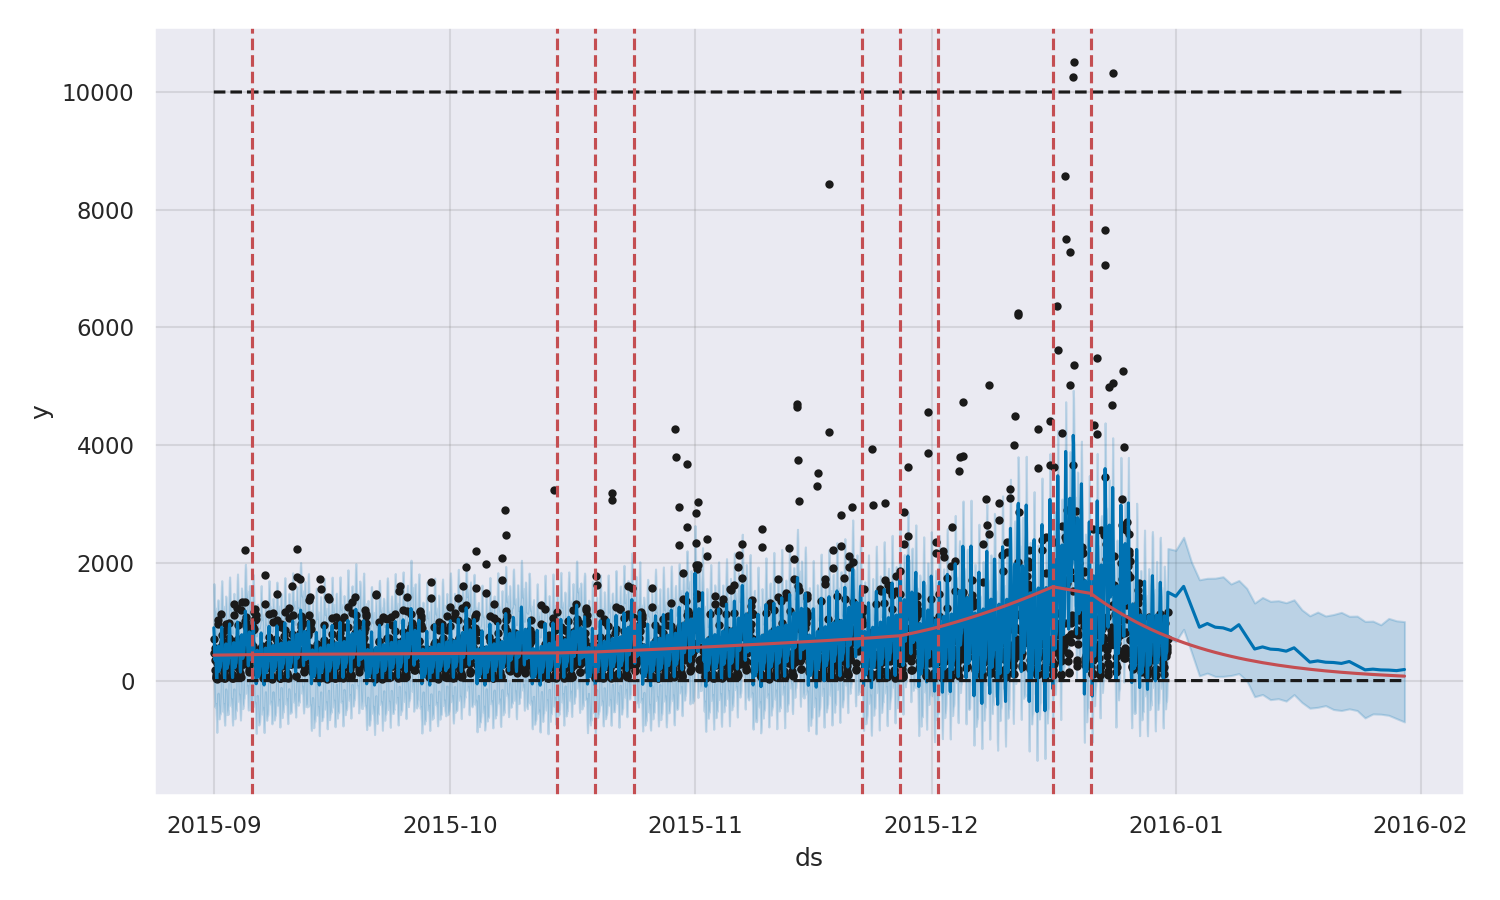

<IPython.core.display.Javascript object>


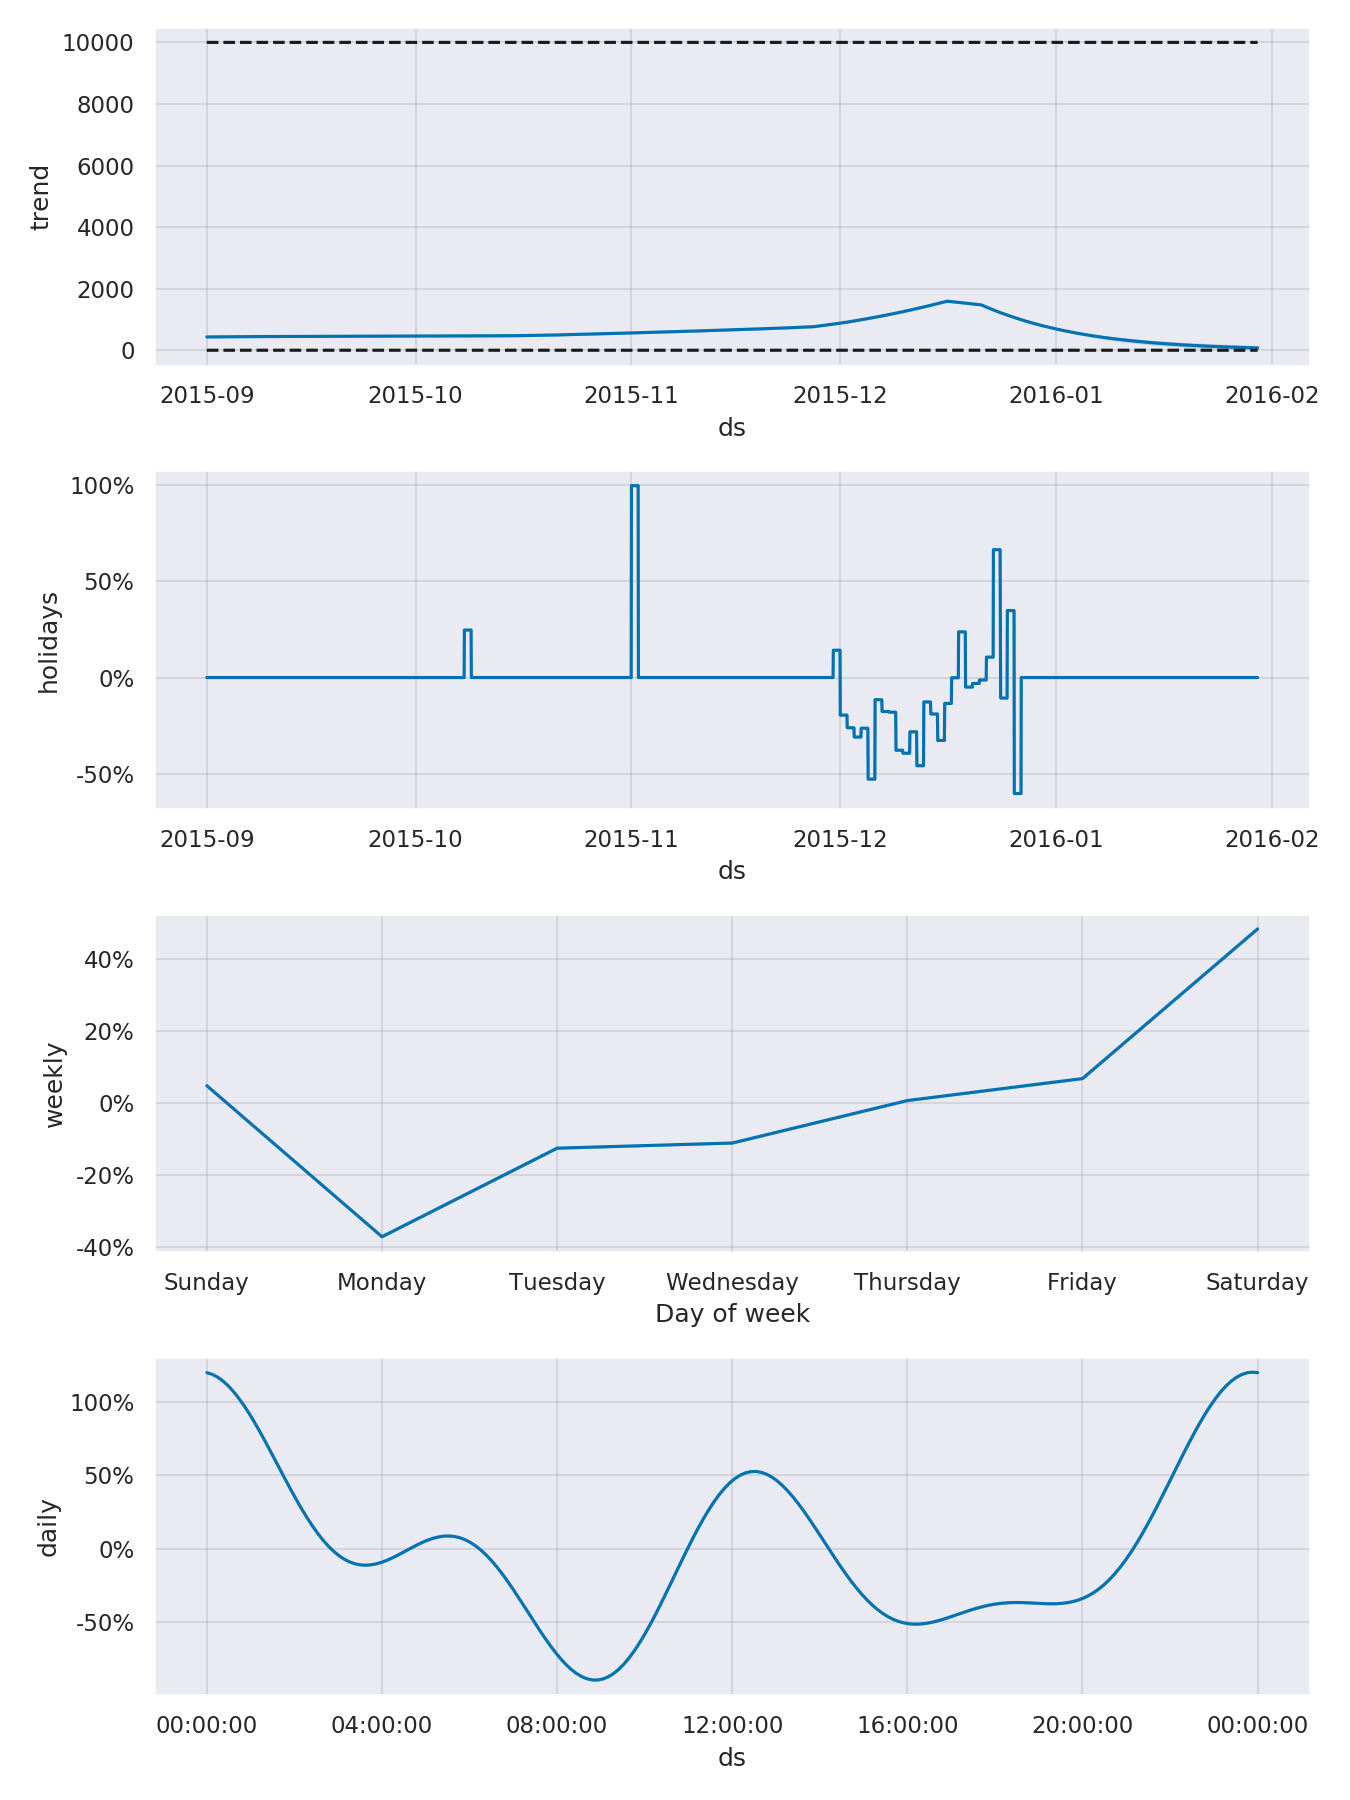

In [25]:
m.plot_components(forecast)
plt.show()

## Plotly interactive graph for closer lookup

In [26]:
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

fig = plot_plotly(m, forecast)  # This returns a plotly Figure
py.iplot(fig)

## Cross validation making 4 forecasts, like before

In [27]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='60 days', period='15 days', horizon = '5 days')
df_cv.head()

INFO:fbprophet:Making 4 forecasts with cutoffs between 2015-11-10 23:00:00 and 2015-12-25 23:00:00


ds         yhat  yhat_lower   yhat_upper    y  \
0 2015-11-11 00:00:00  1083.602274  617.791857  1513.788799  866   
1 2015-11-11 01:00:00  1006.261924  564.454636  1481.810719  643   
2 2015-11-11 02:00:00   817.184567  361.303662  1271.757788  719   
3 2015-11-11 03:00:00   667.765613  192.247614  1167.653077  682   
4 2015-11-11 04:00:00   636.022732  153.610321  1103.656881  417   

               cutoff  
0 2015-11-10 23:00:00  
1 2015-11-10 23:00:00  
2 2015-11-10 23:00:00  
3 2015-11-10 23:00:00  
4 2015-11-10 23:00:00

In [28]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

horizon           mse         rmse         mae      mape  coverage
0   0 days 12:00:00  1.546083e+06  1243.415802  793.395598  1.784716  0.645833
1   0 days 13:00:00  1.691313e+06  1300.504751  828.680865  2.178301  0.625000
2   0 days 14:00:00  1.953990e+06  1397.851758  893.670882  2.473405  0.604167
3   0 days 15:00:00  2.066393e+06  1437.495232  922.968130  2.721210  0.604167
4   0 days 16:00:00  2.117258e+06  1455.080016  941.923816  2.846217  0.604167
..              ...           ...          ...         ...       ...       ...
104 4 days 20:00:00  1.285879e+06  1133.966047  721.090998  1.756466  0.583333
105 4 days 21:00:00  1.300434e+06  1140.365720  718.447443  1.714988  0.583333
106 4 days 22:00:00  1.380954e+06  1175.139909  748.242194  1.693822  0.583333
107 4 days 23:00:00  1.590980e+06  1261.340622  799.374778  1.520297  0.583333
108 5 days 00:00:00  1.942845e+06  1393.859859  861.435028  1.279204  0.604167

[109 rows x 6 columns]

In [29]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

<IPython.core.display.Javascript object>


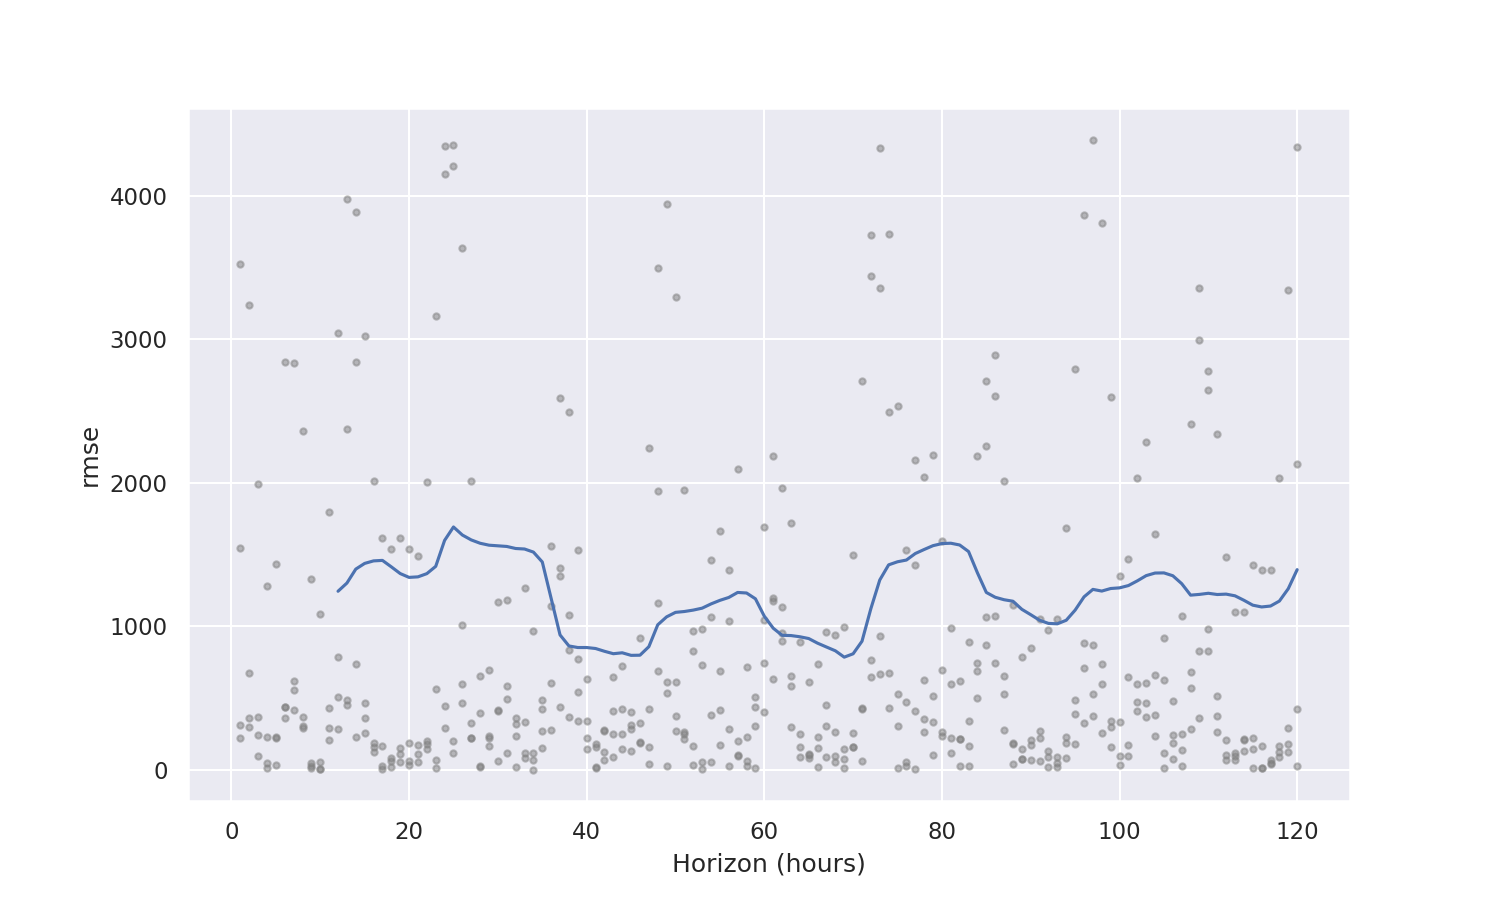

In [30]:
fig.show()

# Conclusion

The improved model has been given christmas and national holidays, as special events, inorder to allow for better predictions. Several settings, as a logistic model for the trend, high and low cutoffs and a multiplicative seasonal mode, have improved the qualitative predictions of the model. The RMSE, however, has even degraded a little, suggesting that this powerfull modelling tool can be tuned even further. 